Mounting Drive for dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**1. IMPORTING LIBRARIES**

In [ ]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)


**2.LOADING FILES**

Taking only those columns that are needed for analysis

In [ ]:
columns=['tpep_pickup_datetime',
           'tpep_dropoff_datetime',
           'trip_distance',
           'pickup_longitude',
           'pickup_latitude',
           'dropoff_longitude',
           'dropoff_latitude',
           'total_amount'
           ]

In [ ]:
file_2015_1 = pd.read_csv('/content/drive/MyDrive/Project work Cdac/yellow_tripdata_2015-01.csv', usecols=columns, nrows=1000000)
file_2015_2 = pd.read_csv('/content/drive/MyDrive/Project work Cdac/yellow_tripdata_2015-02.csv', usecols=columns, nrows=1000000)
file_2015_3 = pd.read_csv('/content/drive/MyDrive/Project work Cdac/yellow_tripdata_2015-03.csv', usecols=columns, nrows=1000000)


Creating dataframes

In [ ]:
#consolidating all the files into 1.
df_2015 = file_2015_1.append(file_2015_2).append(file_2015_3)


In [ ]:
df_2015.shape

(3000000, 8)

In [ ]:
df_2015.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,total_amount
0,2015-01-15 19:05:39,2015-01-15 19:23:42,1.59,-73.993896,40.750111,-73.974785,40.750618,17.05
1,2015-01-10 20:33:38,2015-01-10 20:53:28,3.30,-74.001648,40.724243,-73.994415,40.759109,17.80
2,2015-01-10 20:33:38,2015-01-10 20:43:41,1.80,-73.963341,40.802788,-73.951820,40.824413,10.80
3,2015-01-10 20:33:39,2015-01-10 20:35:31,0.50,-74.009087,40.713818,-74.004326,40.719986,4.80
4,2015-01-10 20:33:39,2015-01-10 20:52:58,3.00,-73.971176,40.762428,-74.004181,40.742653,16.30


In [ ]:
df_2015.dtypes

tpep_pickup_datetime      object
tpep_dropoff_datetime     object
trip_distance            float64
pickup_longitude         float64
pickup_latitude          float64
dropoff_longitude        float64
dropoff_latitude         float64
total_amount             float64
dtype: object

In [ ]:
#Renaming columns
df_2015= df_2015.rename(columns={'tpep_pickup_datetime': 'pickup_time'})
df_2015= df_2015.rename(columns={'tpep_dropoff_datetime': 'dropoff_time'})

In [ ]:
df_2015.head()

,pickup_time,dropoff_time,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,total_amount
0,2015-01-15 19:05:39,2015-01-15 19:23:42,1.59,-73.993896,40.750111,-73.974785,40.750618,17.05
1,2015-01-10 20:33:38,2015-01-10 20:53:28,3.30,-74.001648,40.724243,-73.994415,40.759109,17.80
2,2015-01-10 20:33:38,2015-01-10 20:43:41,1.80,-73.963341,40.802788,-73.951820,40.824413,10.80
3,2015-01-10 20:33:39,2015-01-10 20:35:31,0.50,-74.009087,40.713818,-74.004326,40.719986,4.80
4,2015-01-10 20:33:39,2015-01-10 20:52:58,3.00,-73.971176,40.762428,-74.004181,40.742653,16.30


**3. DATA PREPROCESSING**

1. Removing all the lat and long which are empty,na or nan .Also taking trips that have fare rate greater than 1 and less than 50

In [ ]:
# defining a function for removing empty, na or nan-latitudes and longitudes present in the dataset
def lat_long_cleaning(df):
    df = df.dropna(how='any', axis='rows') #how=any: drop any value with na
    df = df[(df.dropoff_latitude != 0) | (df.dropoff_longitude != 0)]
    df = df[(df.pickup_latitude != 0) | (df.pickup_longitude != 0)]

    if "total_amount" in list(df):
        df = df[df.total_amount.between(1, 50)] #keeping trips only between $1 and $50

    return df



In [ ]:
# calling the clean function for our dataset
df_2015 = lat_long_cleaning(df_2015)


In [ ]:
df_2015.shape

(2843079, 8)

In [ ]:
df_2015.head()

,pickup_time,dropoff_time,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,total_amount
0,2015-01-15 19:05:39,2015-01-15 19:23:42,1.59,-73.993896,40.750111,-73.974785,40.750618,17.05
1,2015-01-10 20:33:38,2015-01-10 20:53:28,3.30,-74.001648,40.724243,-73.994415,40.759109,17.80
2,2015-01-10 20:33:38,2015-01-10 20:43:41,1.80,-73.963341,40.802788,-73.951820,40.824413,10.80
3,2015-01-10 20:33:39,2015-01-10 20:35:31,0.50,-74.009087,40.713818,-74.004326,40.719986,4.80
4,2015-01-10 20:33:39,2015-01-10 20:52:58,3.00,-73.971176,40.762428,-74.004181,40.742653,16.30


2. Removing any coordinates outside the city

In [ ]:
# defining function for removing unwanted coordinates
# Used [https://en.m.wikipedia.org/wiki/Module:Location_map/data/USA_New_York_City] to get city's boundary

def coordinates_cleaning(df):
    nrows = df.shape[0]
    df.drop(df.index[ ~((df['pickup_latitude'].between(40.49, 40.92)) &
              (df['pickup_longitude'].between(-74.27, -73.68)))], inplace=True)

In [ ]:
# calling the coordinates cleaning  function for our dataset
coordinates_cleaning(df_2015)

In [ ]:
df_2015.shape

(2842482, 8)

3.Converting the datatype from object to datetime

In [ ]:
print(df_2015['pickup_time'].dtypes)
print(df_2015['dropoff_time'] .dtypes)

object
object


In [ ]:
df_2015['pickup_time']  = pd.to_datetime(df_2015['pickup_time'])
df_2015['dropoff_time']  = pd.to_datetime(df_2015['dropoff_time'])


In [ ]:
print(df_2015['pickup_time'].dtypes)
print(df_2015['dropoff_time'] .dtypes)

datetime64[ns]
datetime64[ns]


In [ ]:
df_2015.dtypes

pickup_time          datetime64[ns]
dropoff_time         datetime64[ns]
trip_distance               float64
pickup_longitude            float64
pickup_latitude             float64
dropoff_longitude           float64
dropoff_latitude            float64
total_amount                float64
dtype: object

4.Converting the time into minutes and calculating the trip duration by time difference between pickup and dropoff

In [ ]:
trip_duration = np.array(df_2015['dropoff_time']-df_2015['pickup_time'])
trip_duration = trip_duration/1000000000/60 #nanosecondes to minutes: divide by 1000000000 and then by 60

In [ ]:
#Adding this trip duration as new column to our dataset

df_2015['trip_duration'] = trip_duration.astype(float)

In [ ]:
df_2015.shape

(2842482, 9)

In [ ]:
df_2015.head()

,pickup_time,dropoff_time,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,total_amount,trip_duration
0,2015-01-15 19:05:39,2015-01-15 19:23:42,1.59,-73.993896,40.750111,-73.974785,40.750618,17.05,18.0
1,2015-01-10 20:33:38,2015-01-10 20:53:28,3.30,-74.001648,40.724243,-73.994415,40.759109,17.80,19.0
2,2015-01-10 20:33:38,2015-01-10 20:43:41,1.80,-73.963341,40.802788,-73.951820,40.824413,10.80,10.0
3,2015-01-10 20:33:39,2015-01-10 20:35:31,0.50,-74.009087,40.713818,-74.004326,40.719986,4.80,1.0
4,2015-01-10 20:33:39,2015-01-10 20:52:58,3.00,-73.971176,40.762428,-74.004181,40.742653,16.30,19.0


5. Removing all rides that have trip duration less than 0 hours and longer than 2 hours

In [ ]:
df_2015.drop(df_2015[(df_2015['trip_duration'] > 120) |
               (df_2015['trip_duration'] <= 0)].index, inplace = True)


In [ ]:
df_2015.shape

(2798974, 9)

In [ ]:
df_2015.head()

,pickup_time,dropoff_time,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,total_amount,trip_duration
0,2015-01-15 19:05:39,2015-01-15 19:23:42,1.59,-73.993896,40.750111,-73.974785,40.750618,17.05,18.0
1,2015-01-10 20:33:38,2015-01-10 20:53:28,3.30,-74.001648,40.724243,-73.994415,40.759109,17.80,19.0
2,2015-01-10 20:33:38,2015-01-10 20:43:41,1.80,-73.963341,40.802788,-73.951820,40.824413,10.80,10.0
3,2015-01-10 20:33:39,2015-01-10 20:35:31,0.50,-74.009087,40.713818,-74.004326,40.719986,4.80,1.0
4,2015-01-10 20:33:39,2015-01-10 20:52:58,3.00,-73.971176,40.762428,-74.004181,40.742653,16.30,19.0


6. Removing all rides that have trip distance less than 0 and longer than 60 kms

In [ ]:
df_2015.drop(df_2015[(df_2015['trip_distance'] <= 0) | (df_2015['trip_distance'] > 60)].index, inplace = True)

In [ ]:
df_2015.shape

(2790779, 9)

In [ ]:
df_2015.head()

,pickup_time,dropoff_time,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,total_amount,trip_duration
0,2015-01-15 19:05:39,2015-01-15 19:23:42,1.59,-73.993896,40.750111,-73.974785,40.750618,17.05,18.0
1,2015-01-10 20:33:38,2015-01-10 20:53:28,3.30,-74.001648,40.724243,-73.994415,40.759109,17.80,19.0
2,2015-01-10 20:33:38,2015-01-10 20:43:41,1.80,-73.963341,40.802788,-73.951820,40.824413,10.80,10.0
3,2015-01-10 20:33:39,2015-01-10 20:35:31,0.50,-74.009087,40.713818,-74.004326,40.719986,4.80,1.0
4,2015-01-10 20:33:39,2015-01-10 20:52:58,3.00,-73.971176,40.762428,-74.004181,40.742653,16.30,19.0


**4. DATA CLEANING**

In [ ]:
#missing values
df_2015.isnull().sum()

pickup_time          0
dropoff_time         0
trip_distance        0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
total_amount         0
trip_duration        0
dtype: int64

In [ ]:
#na values
df_2015.isna().sum()

pickup_time          0
dropoff_time         0
trip_distance        0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
total_amount         0
trip_duration        0
dtype: int64

Checking outliers in numerical variables

In [ ]:
print(round(df_2015.describe(),2))
#rounded of the values till 2 points after decimals

       trip_distance  pickup_longitude  pickup_latitude  dropoff_longitude  \
count     2790779.00        2790779.00       2790779.00         2790779.00   
mean            2.41            -73.98            40.75             -73.98   
std             2.28              0.03             0.02               0.41   
min             0.01            -74.26            40.50            -732.55   
25%             1.00            -73.99            40.74             -73.99   
50%             1.63            -73.98            40.75             -73.98   
75%             2.90            -73.97            40.77             -73.96   
max            59.90            -73.68            40.92              -0.00   

       dropoff_latitude  total_amount  trip_duration  
count        2790779.00    2790779.00     2790779.00  
mean              40.75         13.69          11.79  
std                0.26          8.08           8.14  
min                0.67          1.06           1.00  
25%               40.7

In [ ]:
df_2015.shape

(2790779, 9)

After data preprocessing and data cleaning , the current dataset consists of 2790779 rows and 9 columns.

**5. TRAINING THE MODEL USING K-MEANS ALGORITHM**

It is an iterative algorithm that divides the unlabeled dataset into k different clusters in such a way that each dataset belongs only one group that has similar properties.
The k-means clustering algorithm mainly performs two tasks:

Determines the best value for K center points or centroids by an iterative process.
Assigns each data point to its closest k-center. Those data points which are near to the particular k-center, create a cluster.

In [ ]:
df_2015.head()

,pickup_time,dropoff_time,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,total_amount,trip_duration,Regions
0,2015-01-15 19:05:39,2015-01-15 19:23:42,1.59,-73.993896,40.750111,-73.974785,40.750618,17.05,18.0,4
1,2015-01-10 20:33:38,2015-01-10 20:53:28,3.30,-74.001648,40.724243,-73.994415,40.759109,17.80,19.0,6
2,2015-01-10 20:33:38,2015-01-10 20:43:41,1.80,-73.963341,40.802788,-73.951820,40.824413,10.80,10.0,3
3,2015-01-10 20:33:39,2015-01-10 20:35:31,0.50,-74.009087,40.713818,-74.004326,40.719986,4.80,1.0,6
4,2015-01-10 20:33:39,2015-01-10 20:52:58,3.00,-73.971176,40.762428,-74.004181,40.742653,16.30,19.0,2


In [ ]:
#Using a variable named "pickup_coordinates" to get the coordinates based on the combination of pickup_latitude and pickup_longitude values
pickup_coordinates = df_2015[["pickup_latitude", "pickup_longitude"]].values


In [ ]:
#Using a variable named "dropoff_coordinates" to get the coordinates based on the combination of pickup_latitude and pickup_longitude values
dropoff_coordinates = df_2015[["dropoff_latitude", "dropoff_longitude"]].values


In [ ]:
print(pickup_coordinates)

[[ 40.75011063 -73.99389648]
 [ 40.72424316 -74.00164795]
 [ 40.80278778 -73.96334076]
 ...
 [ 40.67432022 -73.98191071]
 [ 40.77515411 -73.98181915]
 [ 40.72156906 -74.00840759]]


In [ ]:
print(dropoff_coordinates)

[[ 40.75061798 -73.97478485]
 [ 40.7591095  -73.99441528]
 [ 40.8244133  -73.95182037]
 ...
 [ 40.68458176 -73.97773743]
 [ 40.85403061 -73.93019867]
 [ 40.71153641 -74.01004791]]


In [ ]:
# converting the array to dataframe
pickup_coord = pd.DataFrame(pickup_coordinates, columns = ['pickup_latitude','pickup_longitude'])

print(pickup_coord)
print(type(pickup_coord))

         pickup_latitude  pickup_longitude
0              40.750111        -73.993896
1              40.724243        -74.001648
2              40.802788        -73.963341
3              40.713818        -74.009087
4              40.762428        -73.971176
...                  ...               ...
2790774        40.743954        -73.984634
2790775        40.741035        -73.997742
2790776        40.674320        -73.981911
2790777        40.775154        -73.981819
2790778        40.721569        -74.008408

[2790779 rows x 2 columns]
<class 'pandas.core.frame.DataFrame'>


In [ ]:
# converting the array to dataframe
dropoff_coord = pd.DataFrame(dropoff_coordinates, columns = ['dropoff_latitude','dropoff_longitude'])

print(dropoff_coord)
print(type(dropoff_coord))

         dropoff_latitude  dropoff_longitude
0               40.750618         -73.974785
1               40.759109         -73.994415
2               40.824413         -73.951820
3               40.719986         -74.004326
4               40.742653         -74.004181
...                   ...                ...
2790774         40.728706         -73.987602
2790775         40.733585         -73.980453
2790776         40.684582         -73.977737
2790777         40.854031         -73.930199
2790778         40.711536         -74.010048

[2790779 rows x 2 columns]
<class 'pandas.core.frame.DataFrame'>


In [ ]:
#Trainging and creating regions when fix number of regions are to be made. For ex: 30 hotspots are to be made.
#regions = KMeans(n_clusters = 30).fit(pickup_coordinates)

In [ ]:
#Predicting Clusters using the above trained model
#cluster_column = regions.predict(df_2015[["pickup_latitude", "pickup_longitude"]])
#df_2015["pickup_cluster"] = cluster_column


In [ ]:
#print(regions)

Training the model such that it can report how many regions can be created

In [ ]:
pickup_regions = KMeans(init='random').fit(pickup_coordinates)

In [ ]:
dropoff_regions = KMeans(init='random').fit(dropoff_coordinates)

Now our dataset is trained , we'll use this trained model to predict the regions

In [ ]:
#using a variable named "pickup_cluster_column" to predict the regions created.
pickup_cluster_column = pickup_regions.predict(df_2015[["pickup_latitude", "pickup_longitude"]])
print(pickup_cluster_column)


[4 6 3 ... 6 2 6]


In [ ]:
#using a variable named "dropoff_cluster_column" to predict the regions created
dropoff_cluster_column = dropoff_regions.predict(df_2015[["pickup_latitude", "pickup_longitude"]])


As we are more focused on pickup points rather than drop off points, we'll work on pickup points only.

In [ ]:
#saving the pickup regions generated into a new column and adding that column to our dataset .

df_2015["Regions"] = pickup_cluster_column

In [ ]:
df_2015.head(10)

,pickup_time,dropoff_time,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,total_amount,trip_duration,Regions
0,2015-01-15 19:05:39,2015-01-15 19:23:42,1.59,-73.993896,40.750111,-73.974785,40.750618,17.05,18.0,4
1,2015-01-10 20:33:38,2015-01-10 20:53:28,3.30,-74.001648,40.724243,-73.994415,40.759109,17.80,19.0,6
2,2015-01-10 20:33:38,2015-01-10 20:43:41,1.80,-73.963341,40.802788,-73.951820,40.824413,10.80,10.0,3
3,2015-01-10 20:33:39,2015-01-10 20:35:31,0.50,-74.009087,40.713818,-74.004326,40.719986,4.80,1.0,6
4,2015-01-10 20:33:39,2015-01-10 20:52:58,3.00,-73.971176,40.762428,-74.004181,40.742653,16.30,19.0,2
5,2015-01-10 20:33:39,2015-01-10 20:53:52,9.00,-73.874374,40.774048,-73.986977,40.758194,40.33,20.0,5
6,2015-01-10 20:33:39,2015-01-10 20:58:31,2.20,-73.983276,40.726009,-73.992470,40.749634,15.30,24.0,0
7,2015-01-10 20:33:39,2015-01-10 20:42:20,0.80,-74.002663,40.734142,-73.995010,40.726326,9.96,8.0,4
9,2015-01-10 20:33:40,2015-01-10 20:40:44,0.90,-73.985588,40.767948,-73.985916,40.759365,9.35,7.0,2
10,2015-01-10 20:33:40,2015-01-10 20:41:39,0.90,-73.988617,40.723103,-74.004395,40.728584,9.96,7.0,0


In [ ]:
df_2015.shape

(2790779, 10)

In [ ]:
regions = list(set(df_2015["Regions"]))
print(regions)

[0, 1, 2, 3, 4, 5, 6, 7]


In [ ]:
pd.DataFrame(pickup_coordinates).to_csv("pickup_coordinates.csv")

**6.DATA VISUALIZATION**

Checking coorelation

In [ ]:
correlation = df_2015.corr()
correlation

,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,total_amount,trip_duration,Regions
trip_distance,1.000000,0.321885,-0.103294,0.026985,-0.009239,0.936250,0.731904,0.175781
pickup_longitude,0.321885,1.000000,0.264883,0.030203,0.011265,0.272835,0.138281,-0.140813
pickup_latitude,-0.103294,0.264883,1.000000,0.007417,0.057087,-0.089454,-0.081615,-0.335404
dropoff_longitude,0.026985,0.030203,0.007417,1.000000,0.003015,0.022412,0.012574,-0.004289
dropoff_latitude,-0.009239,0.011265,0.057087,0.003015,1.000000,-0.010736,-0.012241,-0.017765
total_amount,0.936250,0.272835,-0.089454,0.022412,-0.010736,1.000000,0.853651,0.163295
trip_duration,0.731904,0.138281,-0.081615,0.012574,-0.012241,0.853651,1.000000,0.122196
Regions,0.175781,-0.140813,-0.335404,-0.004289,-0.017765,0.163295,0.122196,1.000000


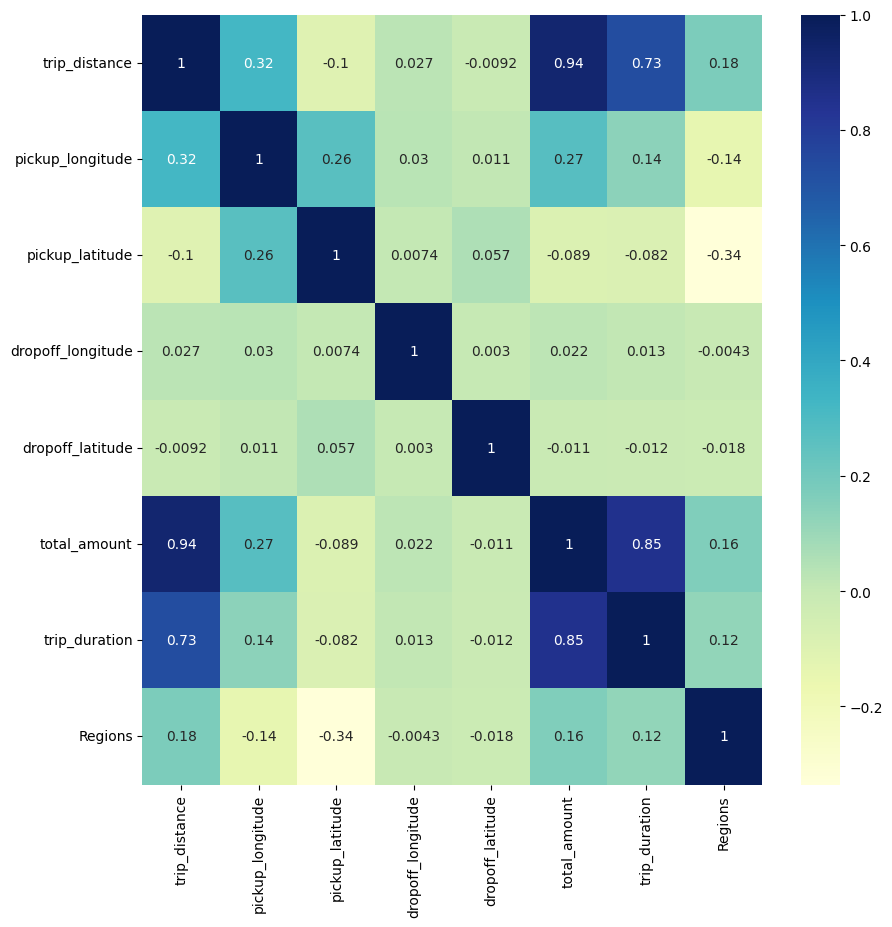

In [ ]:
#Checking the corelation between the variables
plt.figure(figsize = (10, 10))
sns.heatmap(df_2015.corr(), annot = True, cmap="YlGnBu")
plt.savefig("map")
plt.show()

Observation :
The correlation map shows that:
1.   trip duration is highly correlated with trip_amount
2.   trip_Amount is highly correlated with trip distance





Bivariant analysis

<Axes: xlabel='pickup_longitude', ylabel='Regions'>

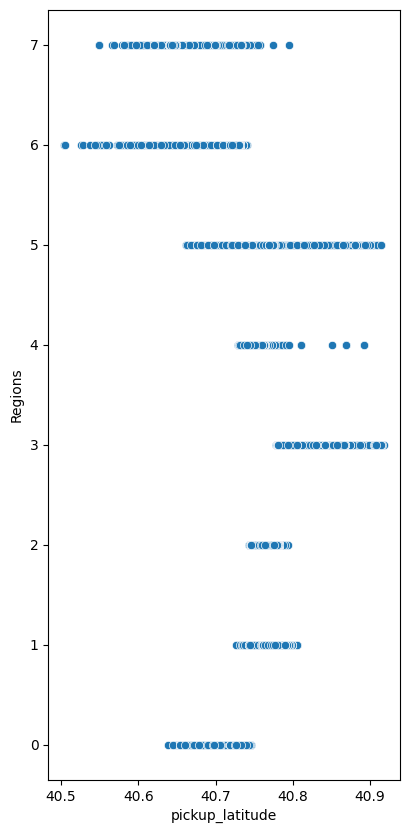

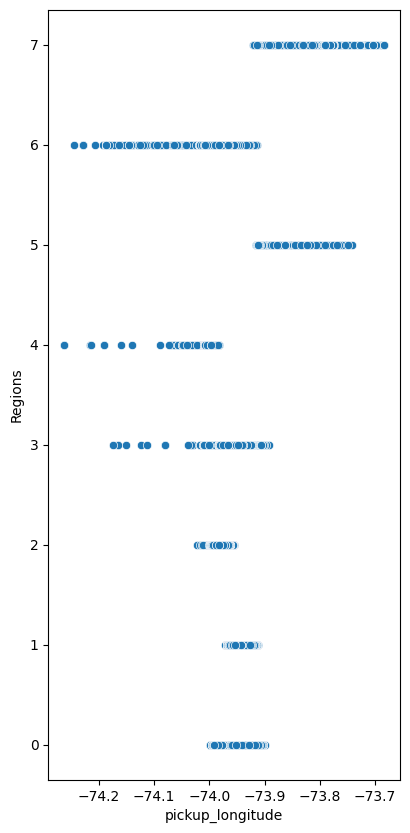

In [ ]:
 # pickup_latitude vs Regions
plt.figure(figsize = (10, 10))
plt.subplot(1,2,1)
sns.scatterplot(x = 'pickup_latitude', y = "Regions",data = df_2015)

 # pickup_longitude vs Regions
plt.figure(figsize = (10, 10))
plt.subplot(1,2,2)
sns.scatterplot(x = 'pickup_longitude', y = "Regions",data = df_2015)


observation: This shows linear relationship between the variables

Visualizing target variable distribution

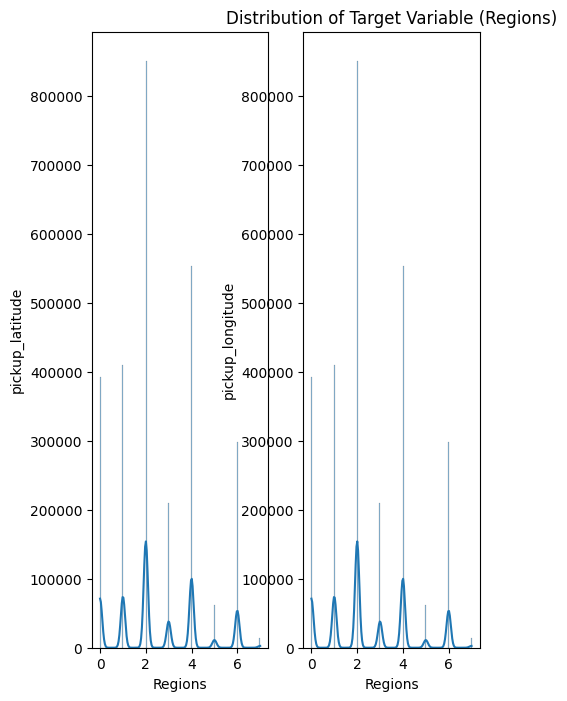

In [ ]:
plt.figure(figsize = (5, 8))

plt.subplot(1,2,1)
sns.histplot(df_2015["Regions"], kde=True)
plt.xlabel('Regions')
plt.ylabel('pickup_latitude')

plt.subplot(1,2,2)
sns.histplot(df_2015["Regions"], kde=True)
plt.xlabel('Regions')
plt.ylabel('pickup_longitude')

plt.title('Distribution of Target Variable (Regions)')
plt.show()

Univariate analysis : Checking distribution of variables

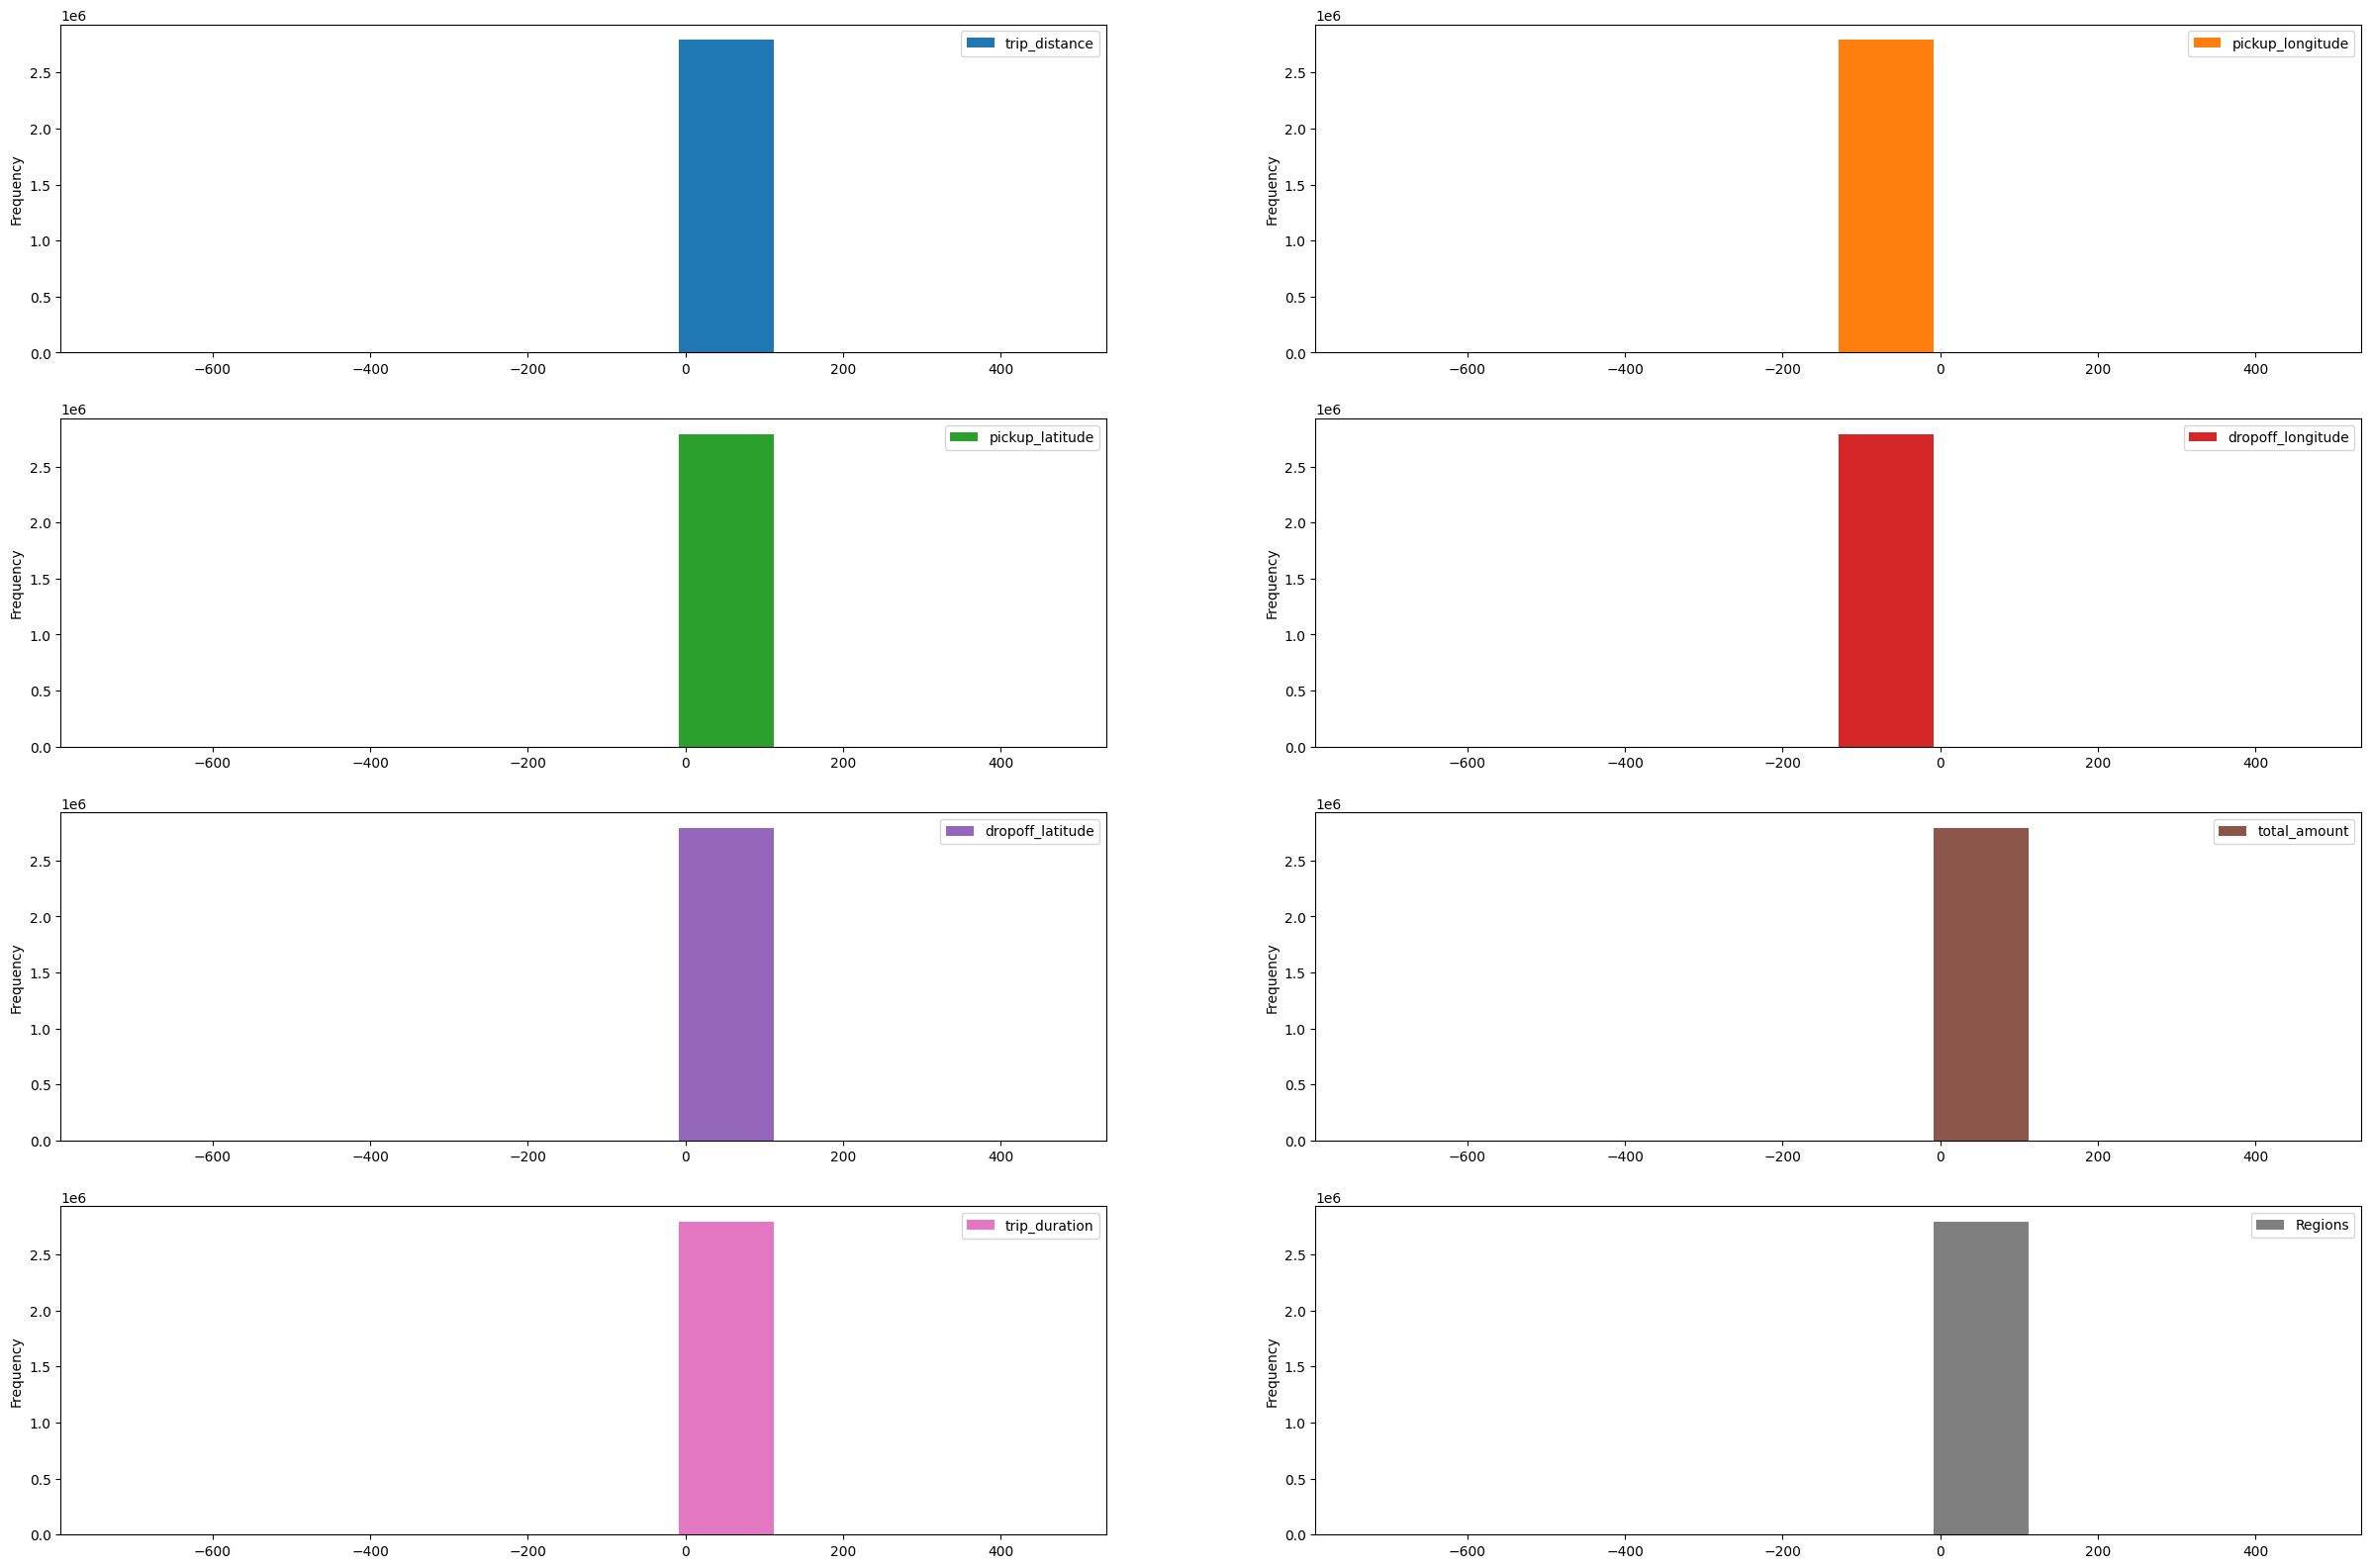

In [ ]:
#histogram for checking the skewness

plt.rcParams['figure.figsize']=(30,25)
df_2015.plot(kind='hist',bins=10, subplots=True, layout=(5,2),sharex=False, sharey=False)
plt.show()


Now, we'll be :
1.creating a dictionary named "hotspot_coordinates" to hold the ‘x’ and ‘y’ co-ordinates of each region.
2.Iterating through dictionary so that the strings are of the form ‘Hot Spot1x’, ‘Hot Spot1y’, ‘Hot Spot2x’, ‘Hot Spot2y’...
These values will be lists of the respective co-ordinates.
3.Also making another dictionary to hold the marker colors for the clusters

Plotting Regions

In [ ]:
hotspot_coordinates={}

#initializing the lists
#regions_count = pickup_cluster_column
for i in regions:
    hotspot_coordinates["Regions"+str(i)+"x"]=[]
    hotspot_coordinates["Regions"+str(i)+"y"]=[]

#make a dictionary to hold the marker colors for the clusters
marker_colors={0:'#00ffff',1:'#faebd7',2:'#7fffd4',3:'#e9967a',4:'#696969',5:'#ff00ff',
               6:'#b0c4de',7:'#5ac18e',8:'#dcedc1',9:'#420420'}

# print(df_2015['hot_spot'])
#appending the co-ordinates according to the cluster specified by target(here, hot_spot)

points_added = 0
for _, x in df_2015.iterrows(): #to iterate on each row and store index(row number) in '_' and row in x
  hotspot_coordinates["Regions"+str(x['Regions'])+"x"].append(x['pickup_latitude'])
  hotspot_coordinates["Regions"+str(x['Regions'])+"y"].append(x['pickup_longitude'])
  points_added = points_added + 1

  if points_added == 100000:
    break



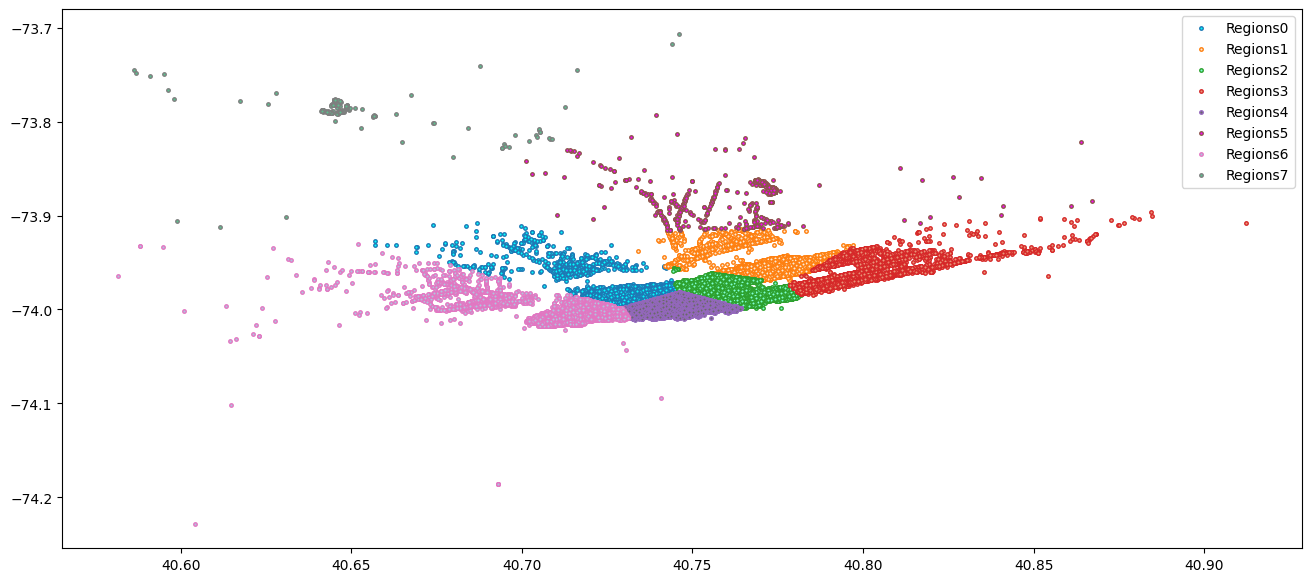

In [ ]:
#plotting the scatterplot
import matplotlib.pyplot as plt

plt.figure(figsize=(16,7))
for i in regions:
    plt.plot(hotspot_coordinates["Regions"+str(i)+"x"],
             hotspot_coordinates["Regions"+str(i)+"y"],
             linestyle='None', marker='.', markersize=5,
             markerfacecolor=marker_colors[i], label="Regions"+str(i))

plt.legend()
plt.show()

Determining the hot spot or the waiting stop out of the regions created.

In [ ]:
print(pickup_regions.cluster_centers_)

[[ 40.73163269 -73.98299593]
 [ 40.77261435 -73.95522781]
 [ 40.76070747 -73.97897785]
 [ 40.79495085 -73.96612839]
 [ 40.74472576 -73.99630379]
 [ 40.76883232 -73.87284267]
 [ 40.71415454 -74.00224832]
 [ 40.64757848 -73.78456997]]


In [ ]:
# for generating a csv to be used on powerBI to display hotspots on a map
hs=pickup_regions.cluster_centers_
pd.DataFrame(hs).to_csv("hs.csv")

Plotting the hot spots or waiting stops

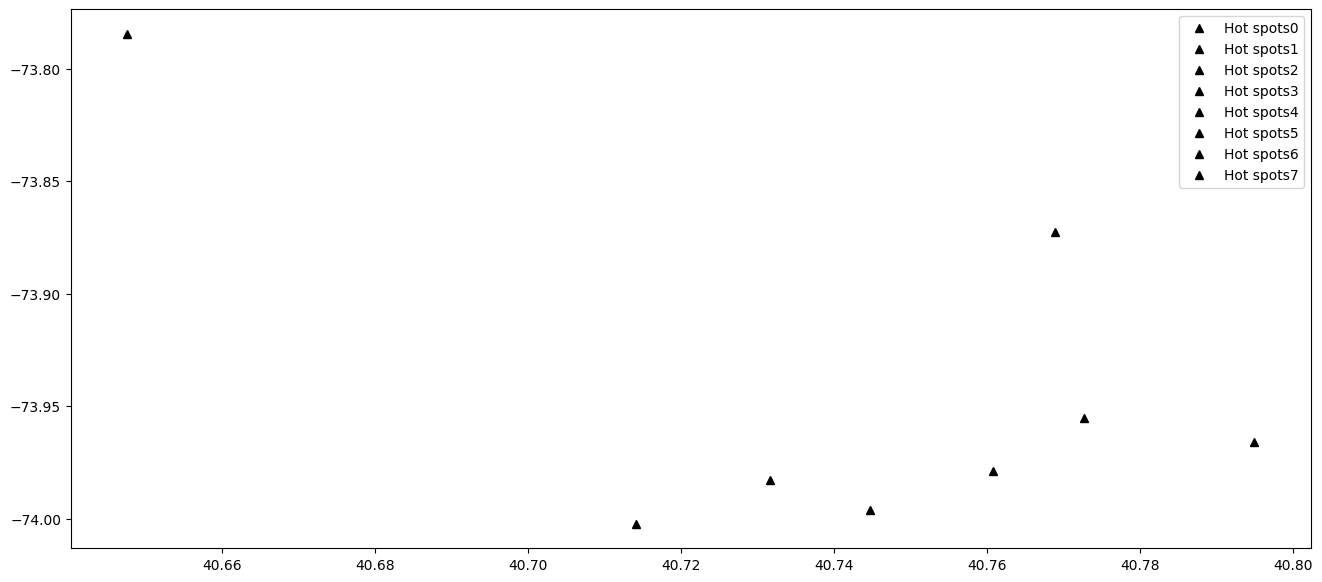

In [ ]:
#plotting the scatterplot
import matplotlib.pyplot as plt

plt.figure(figsize=(16,7))
#cluster_count = len(pickup_regions.cluster_centers_)
for i in regions:
  x, y = pickup_regions.cluster_centers_[i]
  plt.plot(
      x,
      y,
      linestyle='None', marker='^', markersize=6,
      markeredgecolor="#000000", markerfacecolor="#000000",label="Hot spots"+str(i)
  )

plt.legend()
plt.show()

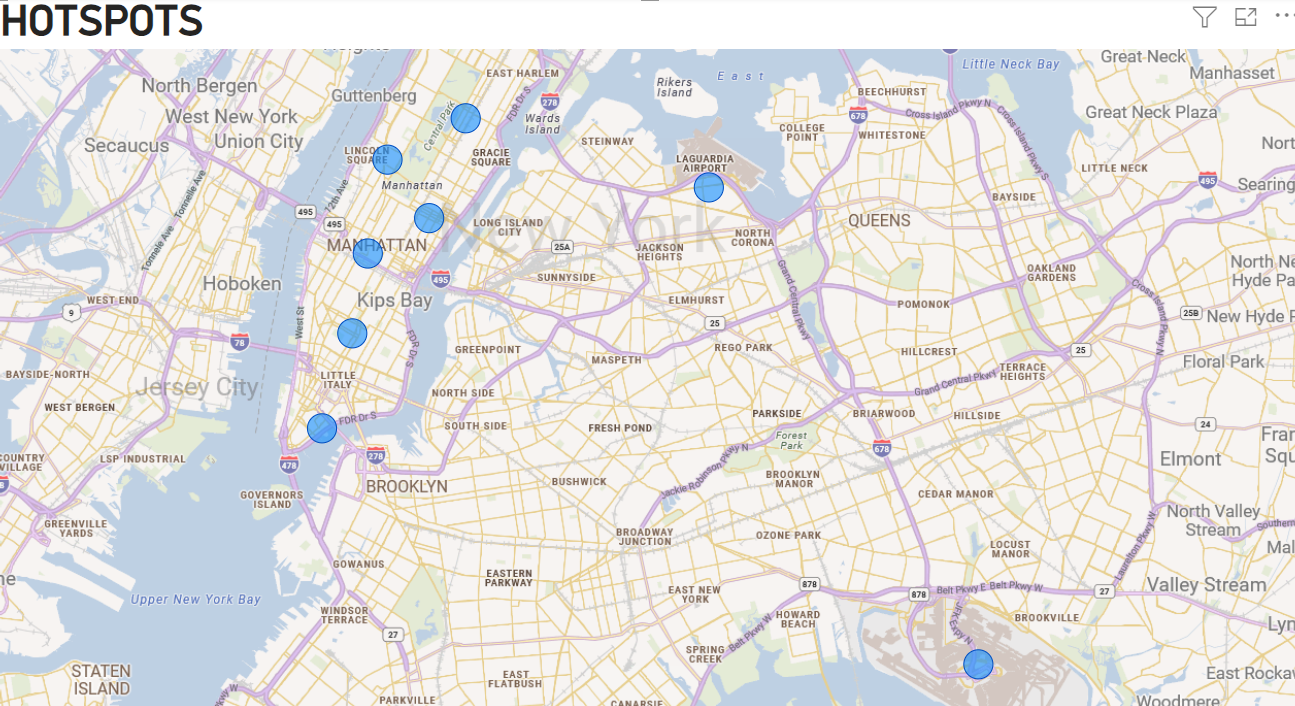

Combining the regions and hotspots map


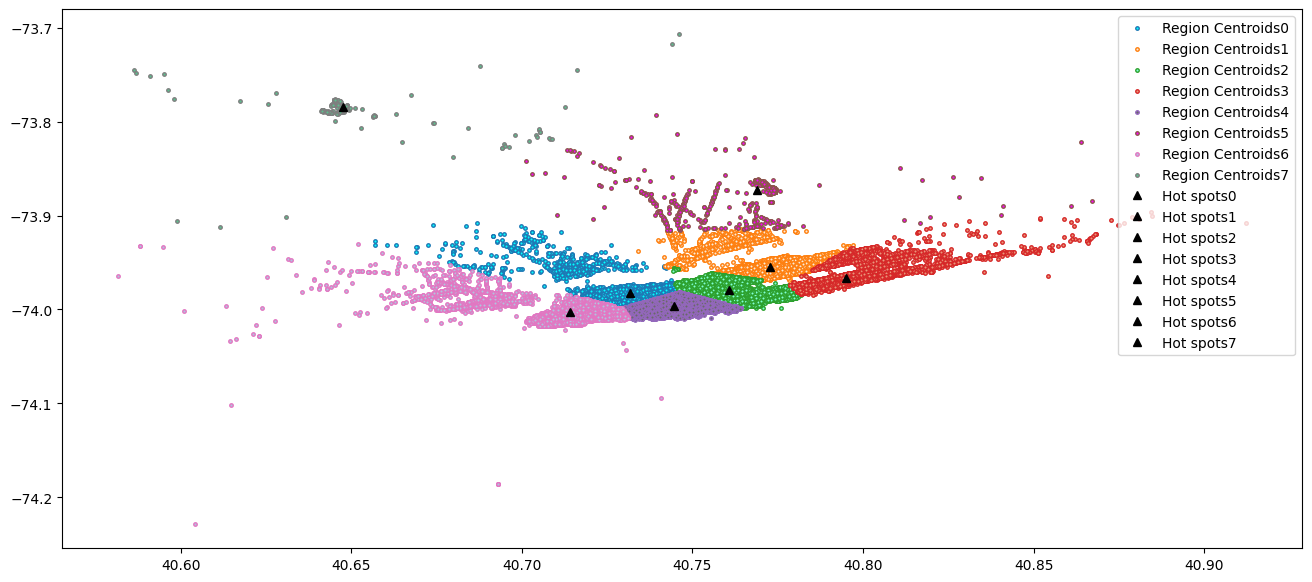

In [ ]:
import matplotlib.pyplot as plt

# Combined Map.
hotspot_coordinates={}

#initializing the lists
for i in regions:
    hotspot_coordinates["Region Centroids"+str(i)+"x"]=[]
    hotspot_coordinates["Region Centroids"+str(i)+"y"]=[]

#make a dictionary to hold the marker colors for the clusters
marker_colors={0:'#00ffff',1:'#faebd7',2:'#7fffd4',3:'#e9967a',4:'#696969',5:'#ff00ff',
               6:'#b0c4de',7:'#5ac18e',8:'#dcedc1',9:'#420420'}

# print(df_2015['hot_spot'])
#appending the co-ordinates according to the cluster specified by target(here, hot_spot)

points_added = 0
for _, x in df_2015.iterrows():
  hotspot_coordinates["Region Centroids"+str(x['Regions'])+"x"].append(x['pickup_latitude'])
  hotspot_coordinates["Region Centroids"+str(x['Regions'])+"y"].append(x['pickup_longitude'])
  points_added = points_added + 1

  if points_added == 100000:
    break

#plotting the hotspots/waiting stops
plt.figure(figsize=(16,7))
for i in regions:
    plt.plot(hotspot_coordinates["Region Centroids"+str(i)+"x"],
             hotspot_coordinates["Region Centroids"+str(i)+"y"],
             linestyle='None', marker='.', markersize=5,
             markerfacecolor=marker_colors[i], label="Region Centroids"+str(i))

cluster_count = len(pickup_regions.cluster_centers_)
for i in range(cluster_count):
  x, y = pickup_regions.cluster_centers_[i]
  plt.plot(
      x,
      y,
      linestyle='None', marker='^', markersize=6,
      markeredgecolor="#000000", markerfacecolor="#000000",label="Hot spots"+str(i)
  )


plt.legend()
plt.show()

**TESTING THE MODEL**

Recommending the nearest hotspot for the customer on the basis of his/her coordinates

In [ ]:
# Get a pickup lat-long combination from customer, and predict the cluster number it belongs to.
customer_output = pickup_regions.predict([[40.68, -74.02]])
print("Your nearest hotspot number is :", customer_output)

Your nearest hotspot number is : [6]
